<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/misc/TF2_Autoencoder_Modified_SNR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special

np.random.seed(42)
tf.random.set_seed(42)

In [18]:
# Parameters
SAMPLE_SIZE = 100000
k = 4
n = 1 # complex channel uses
M = 2**k
TRAINING_SNR_PER_BIT = 7

In [19]:
# Generate Training Data
x = tf.random.uniform(shape=[SAMPLE_SIZE], minval=0, maxval=M, dtype=tf.int64)
input_msg = tf.one_hot(x, M)

In [20]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB] to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*1*ebno)
    return noise_std

In [21]:
noise_std = EbNo_to_noise(TRAINING_SNR_PER_BIT)

# Some custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
channel_layer = keras.layers.Lambda(lambda x: 
                    x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

encoder = keras.models.Sequential([
keras.layers.InputLayer(input_shape=[16]),
keras.layers.Dense(M, activation="relu"),
keras.layers.Dense(2*n, activation=None),
shape_layer,
norm_layer])

channel = keras.models.Sequential([channel_layer])

decoder = keras.models.Sequential([keras.layers.InputLayer(input_shape=[2,n]),
shape_layer2,
keras.layers.Dense(M, activation="relu"),
keras.layers.Dense(M, activation="softmax")
])

autoencoder = keras.models.Sequential([encoder, channel, decoder])

In [22]:
def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [23]:
autoencoder.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=[B_Ber])

In [24]:
history = autoencoder.fit(input_msg, input_msg, epochs=5, batch_size=100)

Epoch 1/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.6781 - B_Ber: 0.5954
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1550 - B_Ber: 0.4546
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.0862 - B_Ber: 0.4252
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.0662 - B_Ber: 0.4163
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.0636 - B_Ber: 0.4120


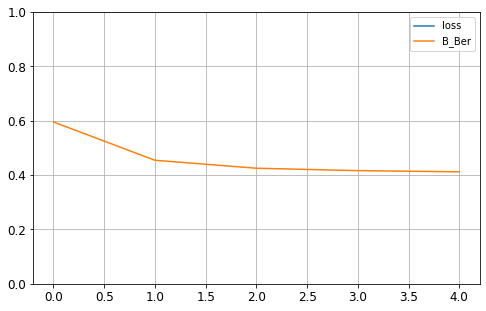

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
# Test coding
inp = np.eye(16, dtype=int)
coding = encoder.predict(inp)

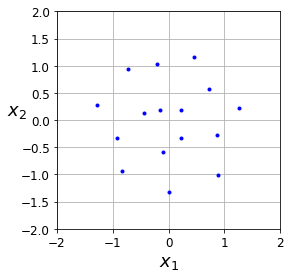

In [27]:
# for n=1 data
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.gca().set_ylim(-2, 2)
plt.gca().set_xlim(-2, 2)
plt.show()

In [28]:
# test msg sequence
test_msg = np.random.randint(M, size=150000)
one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(M)])
data_one_h = one_hot_encoder.fit_transform(test_msg.reshape(-1,1))

In [29]:
def Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 30)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder.predict(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = decoder.predict(rcvd_word)
        bber_vec[db] = B_Ber(data, dcoded_msg)     
    return (snr_range, bber_vec) 

In [30]:
bber_data = Test_AE(data_one_h)

In [31]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

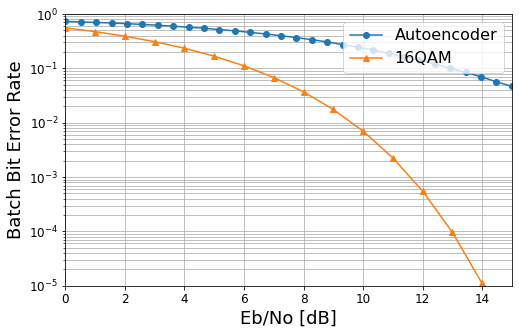

In [32]:
fig = plt.figure(figsize=(8, 5))
# Plot Autoencoder
plt.semilogy(bber_data[0], bber_data[1], 'o-')
# Plot approx 16 QAM
ebnodbs = np.linspace(0,15,16)
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');

plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Bit Error Rate", fontsize=18, rotation=90)
plt.xlabel("Eb/No [dB]", fontsize=18)
plt.legend(['Autoencoder', '16QAM'], prop={'size': 16}, loc='upper right');
plt.grid(True, which="both")